In [1]:
from urllib.request import urlretrieve
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
filename = 'household_power_consumption'
urlretrieve(url, filename)

('household_power_consumption', <http.client.HTTPMessage at 0x7f124b0d6c50>)

In [2]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
with ZipFile('household_power_consumption', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [4]:
import pandas as pd

df = pd.read_csv("household_power_consumption.txt", sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates=[[0, 1]])

In [5]:
df.head()

,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [6]:
df.dtypes

Date_Time                datetime64[ns]
Global_active_power              object
Global_reactive_power            object
Voltage                          object
Global_intensity                 object
Sub_metering_1                   object
Sub_metering_2                   object
Sub_metering_3                  float64
dtype: object

In [7]:
df.isna().sum()

Date_Time                    0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64

In [8]:
count_na = 0
for values in df.values.tolist():
    for value in values:
        if value == '?':
            count_na += 1
        else:
            continue
#Print the result
print('We have {} missing values not captured by isna/isnull command'.format(count_na))

We have 155874 missing values not captured by isna/isnull command


In [10]:
import numpy as np

df2 = df.copy()
# replace "?" to NaN
df.replace("?", np.nan, inplace = True)

#Let's recheck with the isna/isnull command
df.isna().sum()

Date_Time                    0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [11]:
#using a loop to change the datatypes
for column in df.select_dtypes(include=['object']).columns:
    df[[column]] = df[[column]].astype('float')

In [12]:
#check the datatype after the convertion
df.dtypes

Date_Time                datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object

In [13]:
df.isna().sum()

Date_Time                    0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [14]:
df.head()

,Date_Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [15]:
df.set_index('Date_Time', inplace=True)

In [16]:
daily = df.resample('D').sum()
daily.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [17]:
for column in daily.columns:
  if column != 'Date_Time':
    print(column)
    print(round(daily[column].corr(method='pearson', other=daily.Global_active_power), 2))

Global_active_power
1.0
Global_reactive_power
0.13
Voltage
0.27
Global_intensity
1.0
Sub_metering_1
0.55
Sub_metering_2
0.49
Sub_metering_3
0.75


In [18]:
for column in daily.columns:
  if column != 'Date_Time':
    print(column)
    print(round(daily[column].corr(method='pearson', other=daily.Voltage), 2))

Global_active_power
0.27
Global_reactive_power
0.35
Voltage
1.0
Global_intensity
0.27
Sub_metering_1
0.09
Sub_metering_2
0.08
Sub_metering_3
0.28


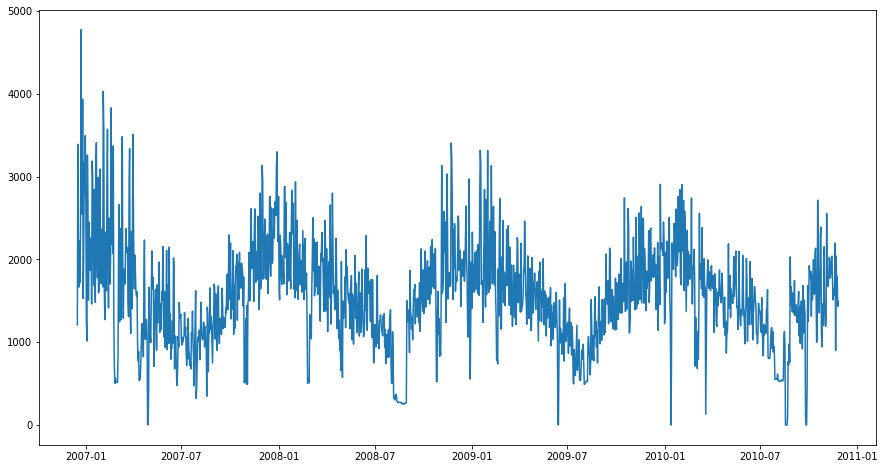

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.plot(daily.Global_active_power)

In [21]:
#checking for zero values in the data

for column in daily.columns:
  print(column)
  print((daily[column].values == 0).sum())

Global_active_power
9
Global_reactive_power
9
Voltage
9
Global_intensity
9
Sub_metering_1
324
Sub_metering_2
20
Sub_metering_3
10


In [22]:
#replace the zeros with the mean of the column
for column in daily.columns:
  daily[column] = daily[column].replace(0, daily[column].mean())

In [23]:
#checking for zero values in the data again to be sure

for column in daily.columns:
  print(column)
  print((daily[column].values == 0).sum())

Global_active_power
0
Global_reactive_power
0
Voltage
0
Global_intensity
0
Sub_metering_1
0
Sub_metering_2
0
Sub_metering_3
0


In [26]:
from fbprophet import Prophet

#using a function
def modelling(data, target, split_size, model):
  #data.interpolate(method='linear')
  split_size = len(data) - split_size
  """
  Using a function to do either a univariate or multivariate forecasting with fbprophet."""
  if model == 'univariate':
    data = data.reset_index()
    columns= data.columns[1:]
    X = data.drop(columns=(columns)) 
    y = data[target]
    X = X.rename(columns={"Date_Time": "ds"})
    y = pd.Series(data=y, name=("y"))
    x_train, y_train, x_test, y_test = X[:split_size], y[:split_size], X[split_size:], y[split_size:]
    train_model = pd.concat([x_train, y_train], axis=1, sort=False)
    test = pd.concat([x_test, y_test], axis=1, sort=False)
    model = Prophet()
    model.fit(train_model)
    forecast = model.predict(x_test)
    plot = model.plot_components(forecast)
    return (plot, forecast, test)

  elif model == 'multivariate':

    data = data.reset_index()
    X = data.drop(columns=(target))
    y = data[target]
    X.rename(columns={"Date_Time": "ds"}, inplace=True)
    y = pd.Series(data=y, name=("y"))
    x_train, y_train, x_test, y_test = X[:split_size], y[:split_size], X[split_size:], y[split_size:]
    train_model = pd.concat([x_train, y_train], axis=1, sort=False)
    test = pd.concat([x_test['ds'], y_test], axis=1, sort=False)
    model = Prophet()
    for column in data.columns:
      if column != target and column != 'Date_Time':
        model.add_regressor(column)
    model.fit(train_model)
    forecast = model.predict(x_test)
    plot = model.plot_components(forecast)
    return (plot, forecast, test)


#A function for metrics
def metrics(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  return (mape, rmse)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NameError: ignored

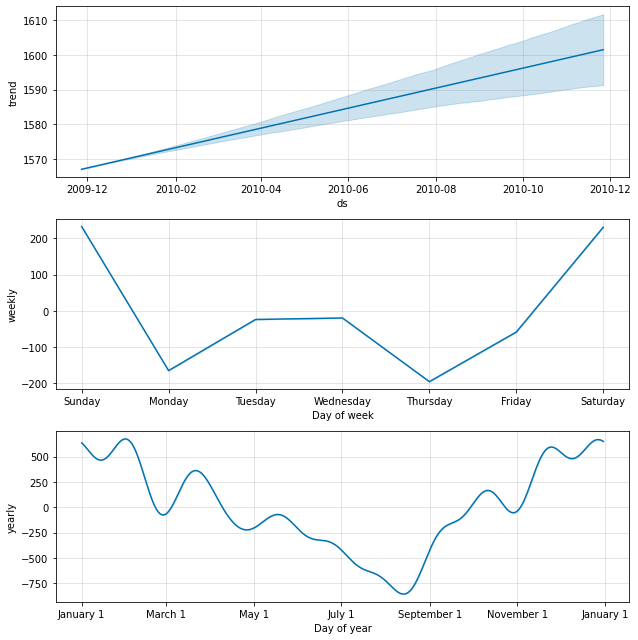

In [29]:
#using the daily data (i.e. mean)
#make predictions for a univariate time series
plot, forecast, test = modelling(data=daily, target='Global_active_power', split_size=365, model='univariate')

#metrics dataframe
metric_df = forecast.set_index('ds')[['yhat']].join(test.set_index('ds')).reset_index()
metric_df.yhat = round(metric_df.yhat, 2)

#take the metrics
mape, rmse = metrics(metric_df.y, metric_df.yhat)

print("MAPE = {} \nRMSE = {}".format(mape, rmse))

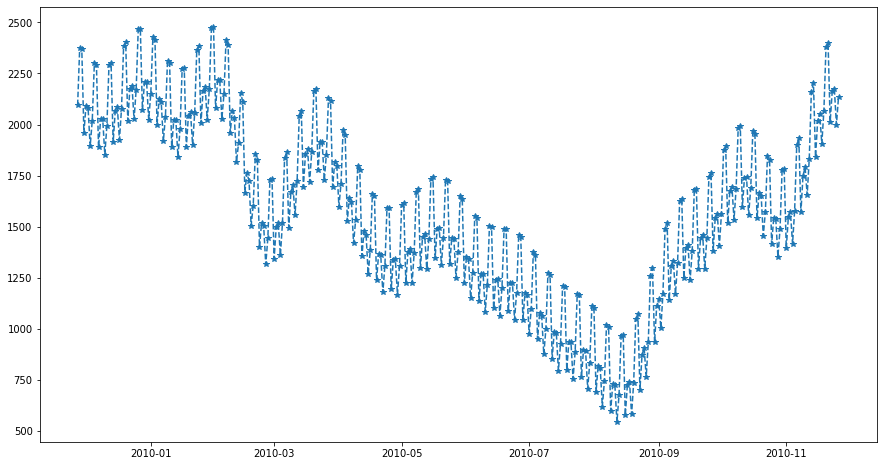

In [30]:
plt.figure(figsize=(15, 8))
plt.plot(forecast.ds, forecast.yhat, '--', marker='*')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


NameError: ignored

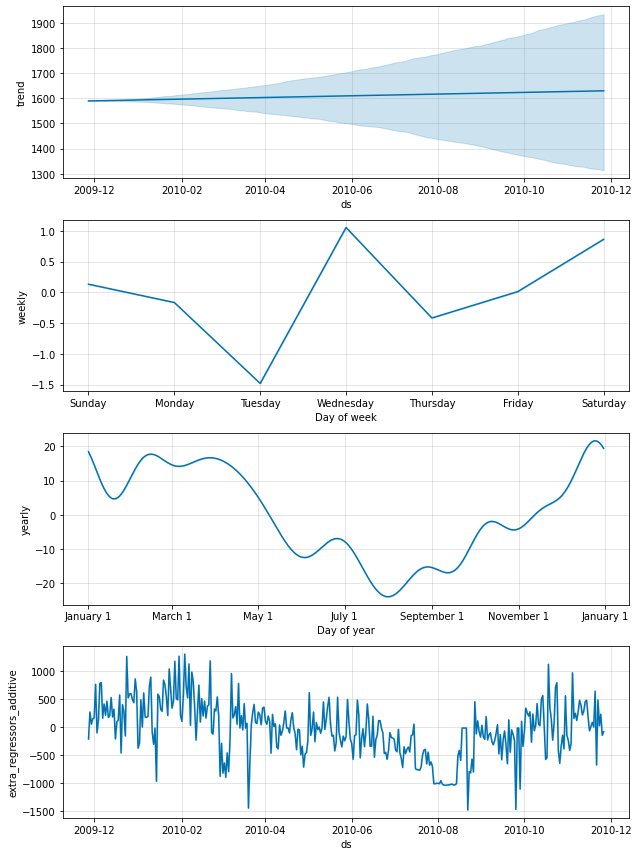

In [31]:
#make predictions for a multivariate time series
plot, forecast, test = modelling(data=daily, target='Global_active_power', split_size=365, model='multivariate')

#metrics dataframe
metric_df = forecast.set_index('ds')[['yhat']].join(test.set_index('ds')).reset_index()
metric_df.yhat = round(metric_df.yhat, 1)

#take the metrics
mape, rmse = metrics(metric_df.y, metric_df.yhat)

print("MAPE = {} \nRMSE = {}".format(mape, rmse))

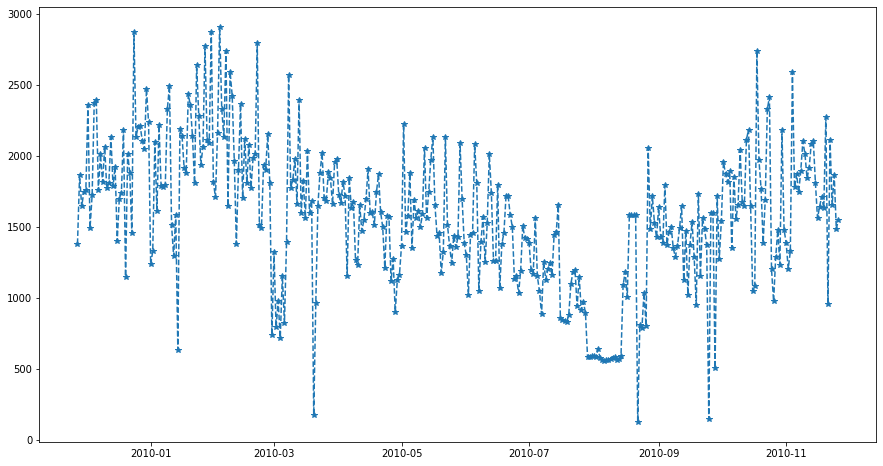

In [32]:
plt.figure(figsize=(15, 8))
plt.plot(forecast.ds, forecast.yhat, '--', marker='*')